In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
'''
The first line reads an Excel file named "dataset.xls" into a pandas DataFrame named "metadata".
This assumes that the file is located in the current working directory.

The second line displays the first five rows of the DataFrame using the ".head()" method,
which is useful for quickly inspecting the contents of the DataFrame and checking that the
data has been imported correctly.
'''
metadata = pd.read_excel("dataset.xls")
metadata.head()

,Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,Difficulty memorizing lessons,Professional objective,Informed about opportunities,Satisfied with living conditions,...,Anxiety symptoms,Panic attack symptoms,Depressive symptoms,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Binge drinking,Marijuana use,Other recreational drugs
0,20 and more,female,yes,humanities,second,no,no,yes,yes,yes,...,no,no,no,no,no,no,no or occasionally,no,no,no
1,19,female,yes,humanities,second,no,no,yes,yes,yes,...,no,no,no,regularly,occasionally to regularly,occasionally,no or occasionally,no,no,no
2,20 and more,female,yes,humanities,second,no,no,yes,yes,yes,...,no,no,yes,no,no,occasionally,no or occasionally,no,no,no
3,19,female,yes,humanities,second,no,no,yes,yes,yes,...,no,no,no,no,no,occasionally,no or occasionally,no,no,no
4,18,female,yes,humanities,second,no,no,yes,yes,yes,...,no,no,no,no,no,no,no or occasionally,no,no,no


# Preprocessing

In [3]:
feat_columns = metadata.columns[metadata.notna().all()].tolist()
selected_features = metadata[feat_columns]

# select all parameters with missing data
missing_data_columns = metadata.columns[metadata.isna().any()].tolist()
missing_data = metadata[missing_data_columns]

In [4]:
'''
Create new DataFrame named "dummy_feat" by applying one-hot encoding to the 'Depressive symptoms' and 'Anxiety symptoms'
columns of the 'selected' DataFrame using the "pd.get_dummies()" function. This creates new columns for each unique value
in the original columns.
'''
dummy_feat = pd.get_dummies(selected_features[['Depressive symptoms','Anxiety symptoms']])
selected_features = selected_features.join(dummy_feat)
selected_features.drop(labels=['Depressive symptoms','Anxiety symptoms'], axis=1, inplace=True)
dummy_feat.head()

,Depressive symptoms_no,Depressive symptoms_yes,Anxiety symptoms_no,Anxiety symptoms_yes
0,1,0,1,0
1,1,0,1,0
2,0,1,1,0
3,1,0,1,0
4,1,0,1,0


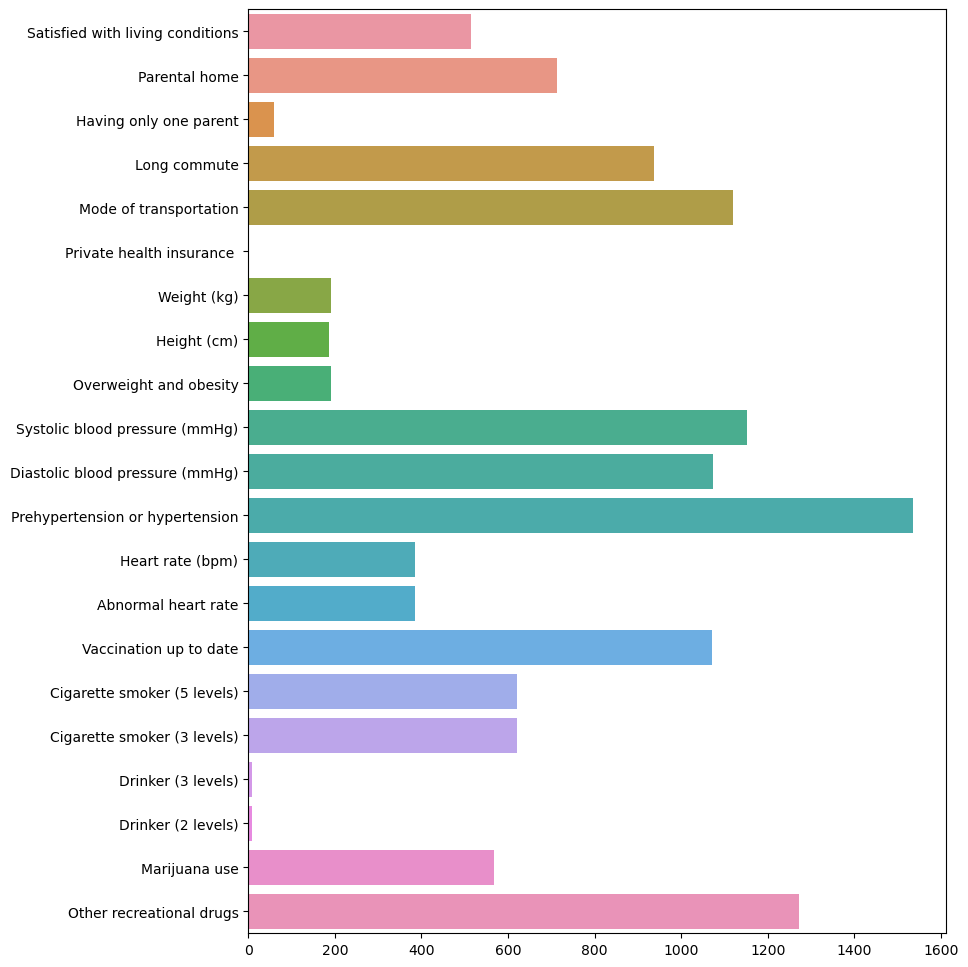

In [5]:
# visualizing nan data in all columns
output = missing_data.isnull().sum()
plt.figure(figsize=(9,12))
sns.barplot(x=output.values, y=output.keys())
plt.show()

In [6]:
'''
Parameters with object values are filtered to replace their string
values with numeric equalent through Label encoder.
Dictionary named "dummy_encoder" stores instances of the LabelEncoder class for each object type column
in a DataFrame named "selected".
For each object column, the code initializes a LabelEncoder object named "le", and then applies the fit_transform
method to the column after converting it to a string data type using the "astype" method. This encodes each
unique value in the column as a numerical label, which can be used as input to machine learning models.

The encoded values are stored in the same column in "selected". Finally, the LabelEncoder instance is added to
the "dummy_encoder" dictionary using the column name as the key. This allows for easy reference to the LabelEncoder
instances later on, if needed.
'''

# for features
features_obj_columns = list(selected_features.select_dtypes(include='object').columns)
features_encoder = {}
for col in features_obj_columns:
    le = LabelEncoder()
    selected_features.loc[:,col] = le.fit_transform(selected_features[col].astype(str))
    features_encoder[col] = le
    
# for missing data
# because label encoder will encode even nan value, so to preserve it
# first we filter out nan data, then we train encoder by skipping nan rows, 
# then create copy of that column and transform str data by skipping nan rows
missing_obj_columns = list(missing_data.select_dtypes(include='object').columns)
missing_encoder = {}
for col in missing_obj_columns:
    le = LabelEncoder()
    nan_mask = missing_data[col].isna()
    le.fit_transform(missing_data[col][~nan_mask])
    col_copy = missing_data[col].copy()
    col_copy.loc[~nan_mask] = le.transform(missing_data[col][~nan_mask])
    missing_data.loc[:,col] = col_copy.astype('float64')
    missing_encoder[col] = le

In [7]:
selected_features.head()

,Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,Difficulty memorizing lessons,Professional objective,Informed about opportunities,Living with a partner/child,...,Urinalysis leukocyturia),Urinalysis (positive nitrite test),Abnormal urinalysis,Control examination needed,Panic attack symptoms,Binge drinking,Depressive symptoms_no,Depressive symptoms_yes,Anxiety symptoms_no,Anxiety symptoms_yes
0,2,0,1,0,1,0,0,1,1,0,...,1,0,1,1,0,0,1,0,1,0
1,1,0,1,0,1,0,0,1,1,0,...,1,0,1,0,0,0,1,0,1,0
2,2,0,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,1,0
3,1,0,1,0,1,0,0,1,1,0,...,1,0,1,0,0,0,1,0,1,0
4,0,0,1,0,1,0,0,1,1,0,...,0,0,1,0,0,0,1,0,1,0


In [8]:
missing_data.head()

,Satisfied with living conditions,Parental home,Having only one parent,Long commute,Mode of transportation,Private health insurance,Weight (kg),Height (cm),Overweight and obesity,Systolic blood pressure (mmHg),...,Prehypertension or hypertension,Heart rate (bpm),Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,1.0,0.0,0.0,0.0,2.0,0.0,62.0,165.0,0.0,NaN,...,NaN,75.0,0.0,NaN,2.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,1.0,1.0,1.0,57.0,170.0,0.0,10.0,...,0.0,65.0,0.0,NaN,4.0,2.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,NaN,162.0,NaN,11.0,...,0.0,65.0,0.0,NaN,2.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,2.0,1.0,85.0,193.0,0.0,11.0,...,0.0,70.0,0.0,NaN,2.0,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,2.0,1.0,41.0,161.0,0.0,10.0,...,0.0,NaN,NaN,1.0,2.0,1.0,0.0,0.0,0.0,0.0


In [9]:
# create new instance of feature(dummy df) with target containing missing data
# because we have 21 targets, so creating 21 impute data arrays
living_conditions = np.append(selected_features.values, missing_data['Satisfied with living conditions'].values.reshape(-1,1), axis=1)
parental_data = np.append(selected_features.values, missing_data['Parental home'].values.reshape(-1,1), axis=1)
pet_data = np.append(selected_features.values, missing_data['Having only one parent'].values.reshape(-1,1), axis=1)
commute_data = np.append(selected_features.values, missing_data['Long commute'].values.reshape(-1,1), axis=1)
transportation_data = np.append(selected_features.values, missing_data['Mode of transportation'].values.reshape(-1,1), axis=1)
insurance_data = np.append(selected_features.values, missing_data['Private health insurance '].values.reshape(-1,1), axis=1)
weight_data = np.append(selected_features.values, missing_data['Weight (kg)'].values.reshape(-1,1), axis=1)
height_data = np.append(selected_features.values, missing_data['Height (cm)'].values.reshape(-1,1), axis=1)
obesity_data = np.append(selected_features.values, missing_data['Overweight and obesity'].values.reshape(-1,1), axis=1)
systolic_data = np.append(dummy_feat.values, missing_data['Systolic blood pressure (mmHg)'].values.reshape(-1,1), axis=1)
diastolic_data = np.append(dummy_feat.values, missing_data['Diastolic blood pressure (mmHg)'].values.reshape(-1,1), axis=1)
hypertension_data = np.append(selected_features.values, missing_data['Prehypertension or hypertension'].values.reshape(-1,1), axis=1)
heartrate_data = np.append(dummy_feat.values, missing_data['Heart rate (bpm)'].values.reshape(-1,1), axis=1)
abnormal_hr_data = np.append(selected_features.values, missing_data['Abnormal heart rate'].values.reshape(-1,1), axis=1)
vaccination_data = np.append(selected_features.values, missing_data['Vaccination up to date'].values.reshape(-1,1), axis=1)
smoke_lvl5_data = np.append(selected_features.values, missing_data['Cigarette smoker (5 levels)'].values.reshape(-1,1), axis=1)
smoke_lvl3_data = np.append(selected_features.values, missing_data['Cigarette smoker (3 levels)'].values.reshape(-1,1), axis=1)
drinker_lvl3_data = np.append(dummy_feat.values, missing_data['Drinker (3 levels)'].values.reshape(-1,1), axis=1)
drinker_lvl2_data = np.append(dummy_feat.values, missing_data['Drinker (2 levels)'].values.reshape(-1,1), axis=1)
marijuana_data = np.append(dummy_feat.values, missing_data['Marijuana use'].values.reshape(-1,1), axis=1)
drugs_data = np.append(dummy_feat.values, missing_data['Other recreational drugs'].values.reshape(-1,1), axis=1)

### Living Conditions

In [10]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(living_conditions)
living_conditions = knn.transform(living_conditions)

### Parental home

In [11]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(parental_data)
parental_data = knn.transform(parental_data)

### Having only one parent

In [12]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(pet_data)
pet_data = knn.transform(pet_data)

### Long commute

In [13]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(commute_data)
commute_data = knn.transform(commute_data)

## Mode of transportation

In [14]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(transportation_data)
transportation_data = knn.transform(transportation_data)

## Private Health Insurance

In [15]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(insurance_data)
insurance_data = knn.transform(insurance_data)

## Weight

In [16]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(weight_data)
weight_data = knn.transform(weight_data)

## Height

In [17]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(height_data)
height_data = knn.transform(height_data)

## Overweight and Obesity

In [18]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(obesity_data)
obesity_data = knn.transform(obesity_data)

## Systolic BP

In [19]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(systolic_data)
systolic_data = knn.transform(systolic_data)

## Diastolic BP

In [20]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(diastolic_data)
diastolic_data = knn.transform(diastolic_data)

## Hypertension

In [21]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(hypertension_data)
hypertension_data = knn.transform(hypertension_data)

## Heart Rate

In [22]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(heartrate_data)
heartrate_data = knn.transform(heartrate_data)

## Abnormal Heart Rate

In [23]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(abnormal_hr_data)
abnormal_hr_data = knn.transform(abnormal_hr_data)

## Vaccination Data

In [24]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(vaccination_data)
vaccination_data = knn.transform(vaccination_data)

## Smoker LVL 5

In [25]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(smoke_lvl5_data)
smoke_lvl5_data = knn.transform(smoke_lvl5_data)

## Smoke LVL 3

In [26]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(smoke_lvl3_data)
smoke_lvl3_data = knn.transform(smoke_lvl3_data)

## Drinker LVL 3

In [27]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(drinker_lvl3_data)
drinker_lvl3_data = knn.transform(drinker_lvl3_data)

## Drinker LVL 2

In [28]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(drinker_lvl2_data)
drinker_lvl2_data = knn.transform(drinker_lvl2_data)

## Marijuana Use

In [29]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(marijuana_data)
marijuana_data = knn.transform(marijuana_data)

## Recreational Drugs

In [30]:
# predict missing data
knn = KNNImputer(n_neighbors=5)
knn.fit(drugs_data)
drugs_data = knn.transform(drugs_data)

## Imputing Main DataFrame

In [31]:
missing_data.loc[:,'Satisfied with living conditions'] = np.round(living_conditions[:,-1]).astype('int')
missing_data.loc[:,'Parental home'] = np.round(parental_data[:,-1]).astype('int')
missing_data.loc[:,'Having only one parent'] = np.round(pet_data[:,-1]).astype('int')
missing_data.loc[:,'Long commute'] = np.round(commute_data[:,-1]).astype('int')
missing_data.loc[:,'Mode of transportation'] = np.round(transportation_data[:,-1]).astype('int')
missing_data.loc[:,'Private health insurance '] = np.round(insurance_data[:,-1]).astype('int')
missing_data.loc[:,'Weight (kg)'] = weight_data[:,-1]
missing_data.loc[:,'Height (cm)'] = height_data[:,-1]
missing_data.loc[:,'Overweight and obesity'] = np.round(obesity_data[:,-1]).astype('int')
missing_data.loc[:,'Systolic blood pressure (mmHg)'] = systolic_data[:,-1]
missing_data.loc[:,'Diastolic blood pressure (mmHg)'] = diastolic_data[:,-1]
missing_data.loc[:,'Prehypertension or hypertension'] = np.round(hypertension_data[:,-1]).astype('int')
missing_data.loc[:,'Heart rate (bpm)'] = heartrate_data[:,-1]
missing_data.loc[:,'Abnormal heart rate'] = np.round(abnormal_hr_data[:,-1]).astype('int')
missing_data.loc[:,'Vaccination up to date'] = np.round(vaccination_data[:,-1]).astype('int')
missing_data.loc[:,'Cigarette smoker (5 levels)'] = np.round(smoke_lvl5_data[:,-1]).astype('int')
missing_data.loc[:,'Cigarette smoker (3 levels)'] = np.round(smoke_lvl3_data[:,-1]).astype('int')
missing_data.loc[:,'Drinker (3 levels)'] = np.round(drinker_lvl3_data[:,-1]).astype('int')
missing_data.loc[:,'Drinker (2 levels)'] = np.round(drinker_lvl2_data[:,-1]).astype('int')
missing_data.loc[:,'Marijuana use'] = np.round(marijuana_data[:,-1]).astype('int')
missing_data.loc[:,'Other recreational drugs'] = np.round(drugs_data[:,-1]).astype('int')
missing_data.head()

,Satisfied with living conditions,Parental home,Having only one parent,Long commute,Mode of transportation,Private health insurance,Weight (kg),Height (cm),Overweight and obesity,Systolic blood pressure (mmHg),...,Prehypertension or hypertension,Heart rate (bpm),Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,1,0,0,0,2,0,62.0,165.0,0,11.6,...,0,75.0,0,1,2,1,0,0,0,0
1,1,1,0,1,1,1,57.0,170.0,0,10.0,...,0,65.0,0,1,4,2,1,0,0,0
2,1,0,1,0,0,1,64.4,162.0,0,11.0,...,0,65.0,0,1,2,1,1,0,0,0
3,1,0,0,0,2,1,85.0,193.0,0,11.0,...,0,70.0,0,1,2,1,1,0,0,0
4,1,0,0,0,2,1,41.0,161.0,0,10.0,...,0,64.6,0,1,2,1,0,0,0,0


# Feature Forming

For BMI: bmi = weight/height*height

for Mean Arterial Pressure: MAP = DP + 0.412 (SP - DP)
DP = Dystolic Pressure
SP = Systolic Pressure

For Pulse Pressure: PP = SP - DP

In [32]:
'''
Create new df for features which includes 3 features measured from processed features as in paper
'''

features = pd.DataFrame()

features['BMI'] = missing_data['Weight (kg)'] / (missing_data['Height (cm)'] *  0.01 * 2)

features['MAP'] = missing_data['Diastolic blood pressure (mmHg)'] + \
    (0.412 *(missing_data['Systolic blood pressure (mmHg)'] - missing_data['Diastolic blood pressure (mmHg)']) * \
     missing_data['Diastolic blood pressure (mmHg)'] )

features['PP'] = missing_data['Systolic blood pressure (mmHg)'] - missing_data['Diastolic blood pressure (mmHg)']
features.head()

,BMI,MAP,PP
0,18.787879,19.8432,5.6
1,16.764706,15.3000,5.0
2,19.876543,18.5360,4.0
3,22.020725,17.8880,3.0
4,12.732919,15.8880,4.0


In [33]:
# merge all features together
features = features.join(selected_features)
features = features.join(missing_data)
features = features.drop(labels=['Weight (kg)',
                                 'Height (cm)',
                                 'Systolic blood pressure (mmHg)',
                                 'Diastolic blood pressure (mmHg)'],axis=1)
features.head()

,BMI,MAP,PP,Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,Difficulty memorizing lessons,...,Prehypertension or hypertension,Heart rate (bpm),Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,18.787879,19.8432,5.6,2,0,1,0,1,0,0,...,0,75.0,0,1,2,1,0,0,0,0
1,16.764706,15.3000,5.0,1,0,1,0,1,0,0,...,0,65.0,0,1,4,2,1,0,0,0
2,19.876543,18.5360,4.0,2,0,1,0,1,0,0,...,0,65.0,0,1,2,1,1,0,0,0
3,22.020725,17.8880,3.0,1,0,1,0,1,0,0,...,0,70.0,0,1,2,1,1,0,0,0
4,12.732919,15.8880,4.0,0,0,1,0,1,0,0,...,0,64.6,0,1,2,1,0,0,0,0


In [34]:
feature_col = features.columns
save_feat = pd.DataFrame()
for col in feature_col:
    if col in features_obj_columns:
        save_feat[col] = features_encoder[col].inverse_transform(features[col])
    elif col in missing_obj_columns:
        save_feat[col] = missing_encoder[col].inverse_transform(features[col])
    else:
        save_feat[col] = features[col]

In [35]:
save_feat.to_csv('KNN_Imputed_dataset.csv')

### Normalization

In [36]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Specify the columns to be normalized
columns_to_normalize = ['BMI', 'MAP', 'PP', 'Heart rate (bpm)']

# Create a new dataframe with the selected columns
X = features.copy()[columns_to_normalize]

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the selected columns
X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])

# Add the remaining non-normalized columns to the new dataframe
remaining_columns = features.drop(columns=columns_to_normalize)
X1 = pd.concat([X, remaining_columns], axis=1)

# The dataframe X now contains the min-max normalized columns along with the other features


In [37]:
X1

,BMI,MAP,PP,Heart rate (bpm),Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,...,Overweight and obesity,Prehypertension or hypertension,Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,0.256726,0.371025,0.510204,0.416667,2,0,1,0,1,0,...,0,0,0,1,2,1,0,0,0,0
1,0.183151,0.192392,0.448980,0.297619,1,0,1,0,1,0,...,0,0,0,1,4,2,1,0,0,0
2,0.296317,0.319627,0.346939,0.297619,2,0,1,0,1,0,...,0,0,0,1,2,1,1,0,0,0
3,0.374292,0.294149,0.244898,0.357143,1,0,1,0,1,0,...,0,0,0,1,2,1,1,0,0,0
4,0.036531,0.215511,0.346939,0.292857,0,0,1,0,1,0,...,0,0,0,1,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179,0.256604,0.423744,0.346939,0.333333,1,1,1,0,0,0,...,0,0,0,1,2,1,1,0,0,0
4180,0.219993,0.423744,0.346939,0.476190,0,1,1,0,0,0,...,0,0,0,1,2,1,0,0,0,0
4181,0.190409,0.433023,0.448980,0.357143,1,0,1,0,0,0,...,0,0,0,1,2,1,1,0,0,0
4182,0.067474,0.320747,0.387755,0.488095,2,1,1,0,0,0,...,0,0,0,1,2,1,1,0,1,0


In [38]:
X = X1.drop(['Anxiety symptoms_no','Anxiety symptoms_yes',
                   'Depressive symptoms_yes','Depressive symptoms_no', 'Panic attack symptoms'], axis=1)
depression = metadata['Depressive symptoms']

In [39]:
X

,BMI,MAP,PP,Heart rate (bpm),Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,...,Overweight and obesity,Prehypertension or hypertension,Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,0.256726,0.371025,0.510204,0.416667,2,0,1,0,1,0,...,0,0,0,1,2,1,0,0,0,0
1,0.183151,0.192392,0.448980,0.297619,1,0,1,0,1,0,...,0,0,0,1,4,2,1,0,0,0
2,0.296317,0.319627,0.346939,0.297619,2,0,1,0,1,0,...,0,0,0,1,2,1,1,0,0,0
3,0.374292,0.294149,0.244898,0.357143,1,0,1,0,1,0,...,0,0,0,1,2,1,1,0,0,0
4,0.036531,0.215511,0.346939,0.292857,0,0,1,0,1,0,...,0,0,0,1,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179,0.256604,0.423744,0.346939,0.333333,1,1,1,0,0,0,...,0,0,0,1,2,1,1,0,0,0
4180,0.219993,0.423744,0.346939,0.476190,0,1,1,0,0,0,...,0,0,0,1,2,1,0,0,0,0
4181,0.190409,0.433023,0.448980,0.357143,1,0,1,0,0,0,...,0,0,0,1,2,1,1,0,0,0
4182,0.067474,0.320747,0.387755,0.488095,2,1,1,0,0,0,...,0,0,0,1,2,1,1,0,1,0


## Oversampling

In [40]:
from imblearn.over_sampling import SMOTE

In [41]:
smote_depression = SMOTE(random_state=42)
X_depression, depression_os = smote_depression.fit_resample(X, depression)

In [42]:
print('New shape:', X_depression.shape)

New shape: (7312, 58)


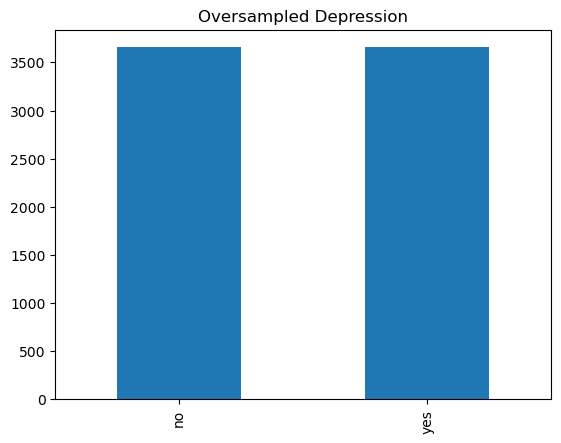

In [43]:
depression_os.value_counts().plot(kind='bar')
plt.title('Oversampled Depression')
plt.show()

# 1.  Important Features (Chi-Squares)

In [44]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2

k = 20  # Number of top features to select
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X_depression, depression_os)

selected_feature_indices_dep = selector.get_support(indices=True)

selected_feature_names_dep = X.columns[selected_feature_indices_dep]

chi2_scores = selector.scores_[selected_feature_indices_dep]

feature_importance_dep_chi2 = pd.DataFrame({'Depression Features': selected_feature_names_dep, 'Chi2 Score': chi2_scores})
feature_importance_dep_chi2 = feature_importance_dep_chi2.sort_values(by='Chi2 Score', ascending=False)

# Print the feature importance results
feature_importance_dep_chi2.head(20)

,Depression Features,Chi2 Score
3,Year of university,182.206936
19,Drinker (3 levels),164.800976
13,Parental home,118.956806
1,Gender,107.224615
12,Binge drinking,101.953846
6,Additional income,83.526316
10,Abnormal urinalysis,81.970060
9,Urinalysis leukocyturia),77.257143
5,At least one parent unemployed,68.231441
16,Overweight and obesity,62.125253


## 2. Important Features (Random Forest)

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_depression, depression_os)

feature_importances_dep_RF = pd.DataFrame({'Depression Features': X_depression.columns, 'Importance': rf.feature_importances_})
feature_importances_dep_RF = feature_importances_dep_RF.sort_values(by='Importance', ascending=False)

# Print the feature importance results
print(feature_importances_dep_RF.head(20))

                 Depression Features  Importance
2                                 PP    0.170851
1                                MAP    0.144908
3                   Heart rate (bpm)    0.078505
0                                BMI    0.067125
7                     Field of study    0.038921
4                     Age (4 levels)    0.029894
54                Drinker (3 levels)    0.029665
43                     Parental home    0.025642
46            Mode of transportation    0.021630
11            Professional objective    0.019720
52       Cigarette smoker (5 levels)    0.019464
26       Physical activity(3 levels)    0.018606
42  Satisfied with living conditions    0.017858
23                  Eating junk food    0.016658
5                             Gender    0.016607
45                      Long commute    0.015856
47         Private health insurance     0.015766
17                             Grant    0.015146
53       Cigarette smoker (3 levels)    0.014860
44            Having

# 3. Imporatant Features (ANOVA)

In [47]:
import pandas as pd
from scipy.stats import f_oneway
import numpy as np

# Perform ANOVA for all features
anova_results = {}
for feature in X_depression.columns:
    f_statistic, p_value = f_oneway(*[X_depression[depression_os == group][feature] for group in np.unique(depression_os)])
    anova_results[feature] = {'F-Statistic': f_statistic, 'P-value': p_value}

# Sort the features based on F-statistic in descending order
sorted_features = sorted(anova_results.items(), key=lambda x: x[1]['F-Statistic'], reverse=True)

# Select the top 20 features with non-NaN values
top_20_features = []
for feature, values in sorted_features:
    if not np.isnan(values['F-Statistic']) and not np.isnan(values['P-value']):
        top_20_features.append(feature)
        if len(top_20_features) == 20:
            break

# Create a dataframe to store the top 20 features and their ANOVA results
top_20_df = pd.DataFrame(columns=['Feature', 'F-Statistic', 'P-value'])
for feature in top_20_features:
    f_statistic = anova_results[feature]['F-Statistic']
    p_value = anova_results[feature]['P-value']
    top_20_df = top_20_df.append({'Feature': feature, 'F-Statistic': f_statistic, 'P-value': p_value}, ignore_index=True)

# Print the top 20 features and their corresponding F-statistic and p-value
print(top_20_df)

                             Feature  F-Statistic       P-value
0                                 PP   366.860494  7.959937e-80
1                 Drinker (3 levels)   383.233282  3.236984e-83
2   Satisfied with living conditions   259.560090  2.067979e-57
3                      Parental home   236.680465  1.380130e-52
4                             Gender   170.217193  1.780287e-38
5          Private health insurance    134.871867  6.570811e-31
6                 Year of university   132.284165  2.363296e-30
7             Professional objective   107.208170  5.958206e-25
8                     Binge drinking   106.240586  9.640629e-25
9                  Additional income    87.219436  1.264704e-20
10               Abnormal urinalysis    84.836273  4.161792e-20
11            Having only one parent    82.142386  1.601085e-19
12          Urinalysis leukocyturia)    79.601153  5.711998e-19
13                               MAP    77.420929  1.702193e-18
14            Vaccination up to date    

## Random  Forest (with Chi Square features)

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Select the top 20 features from the 'feature_importance_Chi2' dataframe
top_20_features = feature_importance_dep_chi2.head(20)['Depression Features'].tolist()

# Create the feature matrix 'X' using the top 20 features
X_dep_chi2 = X_depression[top_20_features]

# Create the target variable 'y'
y_dep_chi2 = depression_os

# Split the data into training and testing sets
X_train_dep_chi2, X_test_dep_chi2, y_train_dep_chi2, y_test_dep_chi2 = train_test_split(X_dep_chi2, y_dep_chi2, test_size=0.3, random_state=42)

In [49]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training set
y_train_encoded_dep_chi2 = label_encoder.fit_transform(y_train_dep_chi2)

# Transform the test set
y_test_encoded_dep_chi2 = label_encoder.transform(y_test_dep_chi2)


In [50]:
# Initialize a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Fit the classifier on the training data
rf_classifier.fit(X_train_dep_chi2, y_train_encoded_dep_chi2)

RandomForestClassifier()

In [51]:
# Predict on the test data
y_pred_dep_chi2 = rf_classifier.predict(X_test_dep_chi2)

In [52]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, accuracy_score, f1_score

# Calculate AUC score
auc_score = roc_auc_score(y_test_encoded_dep_chi2, y_pred_dep_chi2)

# Calculate precision score
precision = precision_score(y_test_encoded_dep_chi2, y_pred_dep_chi2)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded_dep_chi2, y_pred_dep_chi2)

# Calculate F1 score
f1 = f1_score(y_test_encoded_dep_chi2, y_pred_dep_chi2)

# Print the results
print("AUC score for Depression:", auc_score)
print("Precision for Depression:", precision)
print("Accuracy for Depression:", accuracy)
print("F1 score for Depression:", f1)

AUC score for Depression: 0.8075156229224837
Precision for Depression: 0.7965217391304348
Accuracy for Depression: 0.8076572470373746
F1 score for Depression: 0.8127772848269743


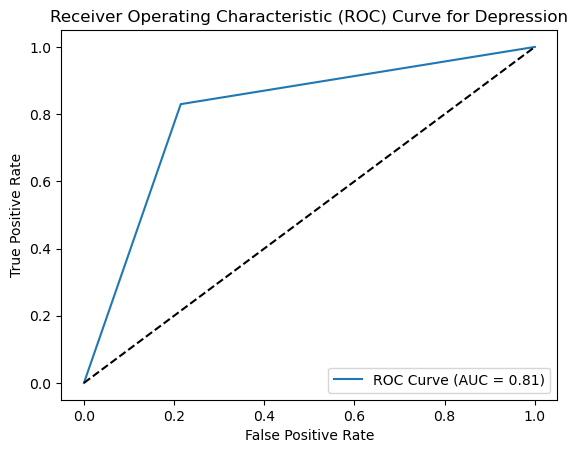

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_encoded_dep_chi2, y_pred_dep_chi2)

# Compute the AUC score
auc_score = roc_auc_score(y_test_encoded_dep_chi2, y_pred_dep_chi2)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Add the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Depression')
plt.legend(loc='lower right')
plt.show()

# Modeling (with RF features)

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Select the top 20 features from the 'feature_importance_Chi2' dataframe
top_20_features = feature_importances_dep_RF.head(20)['Depression Features'].tolist()

# Create the feature matrix 'X' using the top 20 features
X_dep_RF = X_depression[top_20_features]

# Create the target variable 'y'
y_dep_RF = depression_os

# Split the data into training and testing sets
X_train_dep_RF, X_test_dep_RF, y_train_dep_RF, y_test_dep_RF = train_test_split(X_dep_RF, y_dep_RF, test_size=0.3, random_state=42)

In [55]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training set
y_train_encoded_dep_RF = label_encoder.fit_transform(y_train_dep_RF)

# Transform the test set
y_test_encoded_dep_RF = label_encoder.transform(y_test_dep_RF)


### 1. Random Forest

In [56]:
# Initialize a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Fit the classifier on the training data
rf_classifier.fit(X_train_dep_RF, y_train_encoded_dep_RF)

RandomForestClassifier()

In [57]:
# Predict on the test data
y_pred_dep_RF = rf_classifier.predict(X_test_dep_RF)

In [58]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, accuracy_score, f1_score

# Calculate AUC score
auc_score = roc_auc_score(y_test_encoded_dep_RF, y_pred_dep_RF)

# Calculate precision score
precision = precision_score(y_test_encoded_dep_RF, y_pred_dep_RF)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded_dep_RF, y_pred_dep_RF)

# Calculate F1 score
f1 = f1_score(y_test_encoded_dep_RF, y_pred_dep_RF)

recall = recall_score(y_test_encoded_dep_RF, y_pred_dep_RF)

# Print the results
print("AUC score for Depression:", auc_score)
print("Precision for Depression:", precision)
print("Accuracy for Depression:", accuracy)
print("F1 score for Depression:", f1)
print("Recall score for Depression:", recall)

AUC score for Depression: 0.9281628107964366
Precision for Depression: 0.9539347408829175
Accuracy for Depression: 0.9279854147675478
F1 score for Depression: 0.9263746505125816
Recall score for Depression: 0.9003623188405797


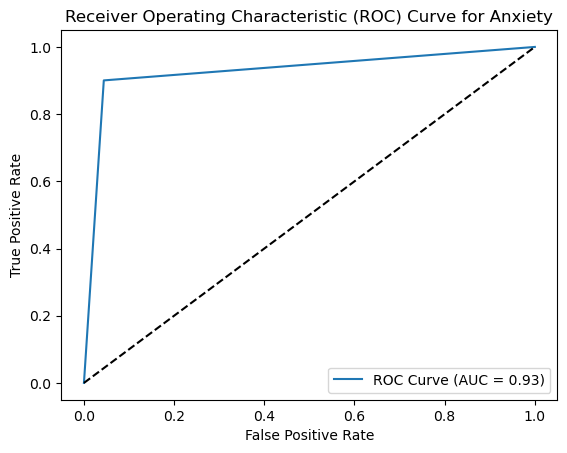

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_encoded_dep_RF, y_pred_dep_RF)

# Compute the AUC score
auc_score = roc_auc_score(y_test_encoded_dep_RF, y_pred_dep_RF)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Add the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Anxiety')
plt.legend(loc='lower right')
plt.show()

### 2. Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train_dep_RF, X_test_dep_RF, y_train_dep_RF, y_test_dep_RF = train_test_split(
    X_dep_RF, y_dep_RF, test_size=0.3, random_state=42
)

# Create a Logistic Regression model with L2 normalization
logreg = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Train the model
logreg.fit(X_train_dep_RF, y_train_encoded_dep_RF)

# Make predictions on the test set
y_pred = logreg.predict(X_test_dep_RF)

# Calculate evaluation metrics
f1 = f1_score(y_test_encoded_dep_RF, y_pred)
accuracy = accuracy_score(y_test_encoded_dep_RF, y_pred)
precision = precision_score(y_test_encoded_dep_RF, y_pred)
recall = recall_score(y_test_encoded_dep_RF, y_pred)
auc = roc_auc_score(y_test_encoded_dep_RF, y_pred)

# Print the evaluation metrics
print("Evaluation Metrics:")
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC Score:", auc)


Evaluation Metrics:
F1 Score: 0.7007626738447734
Accuracy: 0.6959890610756609
Precision: 0.6942222222222222
Recall: 0.707427536231884
AUC Score: 0.6959156029783273


### 3. SVM

In [61]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train_dep_RF, X_test_dep_RF, y_train_dep_RF, y_test_dep_RF = train_test_split(
    X_dep_RF, y_dep_RF, test_size=0.3, random_state=42
)

# Create an SVM model with a polynomial kernel
svm = SVC(kernel='poly', degree=3, random_state=42)

# Train the model
svm.fit(X_train_dep_RF, y_train_encoded_dep_RF)

# Make predictions on the test set
y_pred = svm.predict(X_test_dep_RF)

# Calculate evaluation metrics
f1 = f1_score(y_test_encoded_dep_RF, y_pred)
accuracy = accuracy_score(y_test_encoded_dep_RF, y_pred)
precision = precision_score(y_test_encoded_dep_RF, y_pred)
recall = recall_score(y_test_encoded_dep_RF, y_pred)
auc = roc_auc_score(y_test_encoded_dep_RF, y_pred)

# Print the evaluation metrics
print("Evaluation Metrics:")
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC Score:", auc)


Evaluation Metrics:
F1 Score: 0.7686342093925032
Accuracy: 0.7552415679124886
Precision: 0.7329498767460969
Recall: 0.8079710144927537
AUC Score: 0.7549029384390373


### 4. KNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train_dep_RF, X_test_dep_RF, y_train_dep_RF, y_test_dep_RF = train_test_split(
    X_dep_RF, y_dep_RF, test_size=0.3, random_state=42
)

# Create the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train_dep_RF, y_train_encoded_dep_RF)

# Make predictions on the test set
y_pred = knn.predict(X_test_dep_RF)

# Calculate evaluation metrics
f1 = f1_score(y_test_encoded_dep_RF, y_pred)
accuracy = accuracy_score(y_test_encoded_dep_RF, y_pred)
precision = precision_score(y_test_encoded_dep_RF, y_pred)
recall = recall_score(y_test_encoded_dep_RF, y_pred)
auc = roc_auc_score(y_test_encoded_dep_RF, y_pred)

# Print the evaluation metrics
print("Evaluation Metrics:")
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC Score:", auc)


Evaluation Metrics:
F1 Score: 0.8253205128205129
Accuracy: 0.8012762078395624
Precision: 0.7399425287356322
Recall: 0.9329710144927537
AUC Score: 0.8004304613748172


# Modeling with ANOVA

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Select the top 20 features
selected_features = top_20_df['Feature'].tolist()

# Create the feature matrix X and target variable y
X = X_depression[selected_features]
y = depression_os

# Split the data into training and testing sets
X_train_dep_ANOVA, X_test_dep_ANOVA, y_train_dep_ANOVA, y_test_dep_ANOVA = train_test_split(X, y, test_size=0.3, random_state=42)


In [65]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training set
y_train_encoded_dep_ANOVA = label_encoder.fit_transform(y_train_dep_ANOVA)

# Transform the test set
y_test_encoded_dep_ANOVA = label_encoder.transform(y_test_dep_ANOVA)

In [66]:
# Create an instance of RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train_dep_ANOVA, y_train_encoded_dep_ANOVA)

RandomForestClassifier(random_state=42)

In [67]:
# Predict on the test data
y_pred_dep_ANOVA = rf_classifier.predict(X_test_dep_ANOVA)

In [68]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, accuracy_score, f1_score

# Calculate AUC score
auc_score = roc_auc_score(y_test_encoded_dep_ANOVA, y_pred_dep_ANOVA)

# Calculate precision score
precision = precision_score(y_test_encoded_dep_ANOVA, y_pred_dep_ANOVA)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded_dep_ANOVA, y_pred_dep_ANOVA)

# Calculate F1 score
f1 = f1_score(y_test_encoded_dep_ANOVA, y_pred_dep_ANOVA)

# Print the results
print("AUC score for Anxiety with ANOVA:", auc_score)
print("Precision for Anxiety with ANOVA:", precision)
print("Accuracy for Anxiety with ANOVA:", accuracy)
print("F1 score for Anxiety with ANOVA:", f1)

AUC score for Anxiety with ANOVA: 0.9035201435979259
Precision for Anxiety with ANOVA: 0.9239543726235742
Accuracy for Anxiety with ANOVA: 0.9033728350045579
F1 score for Anxiety with ANOVA: 0.9016697588126161


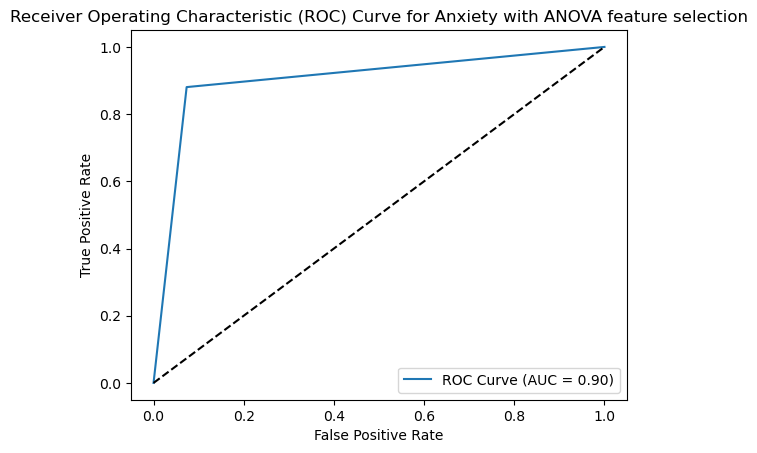

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_encoded_dep_ANOVA, y_pred_dep_ANOVA)

# Compute the AUC score
auc_score = roc_auc_score(y_test_encoded_dep_ANOVA, y_pred_dep_ANOVA)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Add the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Anxiety with ANOVA feature selection')
plt.legend(loc='lower right')
plt.show()